<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Bag of Visual Words - Assignment 2

     Instructor: Kris Kitani                          TAs:Paritosh (Lead), Rawal, Yan, Zen, Wen-Hsuan, Qichen


Perhaps the most common problem in computer vision is classification. Given an image that comes from a few pre-defined categories, can you determine which category it belongs to? For this assignment, you will be developing a system for scene classification. You will be experimenting on a subset of the SUN Image database [3] consisting of eight scene categories and build an end to end system that will, given a new scene image, determine which type of scene it is, as shown in Figure 1.

|![Teaser](figures/teaser/teaser.png)|
|:--:|
|Fig.1 **Scene Classification**: Given an image, can a computer program determine where it was taken? In this homework, you will build a representation based on bags of visual words and use spatial pyramid matching for classifying the scene categories.|

This assignment is based on an approach for document classification called **Bag of Words**. It represents a document as a vector or histogram of counts for each word that occurs in the document, as shown in Figure 2. The hope is that different documents in the same class will have a similar collection and distribution of words, and that when we see a new document, we can find out which class it belongs to by comparing it to the word distribution already seen in that class. This approach has been very successful in Natural Language Processing, which is surprising due to its relative simplicity (we are throwing away all the sequential relationships and representing each document as mere counts of words it contains!).

We will be taking inspiration from this approach and apply it to image classification: imagine each image as a document, and we want to classify each document as a scene. 

|![bagofwords](figures/bagofwords.png)|
|:--:|
|Fig.2 Bag of words representation of a text document|

For this assignment ensure that you use the following versions of libraries
* nbimporter==0.3.4                                
* torch==1.8.1
* torchvision==0.9.1
* numpy==1.19.5
* matplotlib==3.3.4
* opencv-python==4.5.3.56
* scipy==1.5.2
* scikit-image==0.17.2
* scikit-learn==0.24.2
* ipynb==0.5.1
we also provide a requirements.txt. Students can use `pip install -r requirements.txt`.

## For Autograding P1, ensure to upload `dictionary.npy`

This assignment has 4 major sections:

* **P1**: build a dictionary of **visual words** from training data. In this section, you will use Harris corner detector to pick interest points, extract visual words from interest points on images, form a visual dictionary, and represent each image as a vector of visual words. 
* **P2**: build a recognition system using visual word dictionary and training images. In this section, you will use the visual words extracted from the previous section and a technique called __Spatial Pyramid Matching__ to extract visual features from images. You will use these features and ground truth labels to build a simple recognition system.
* **P3**: evaluate the recognition system on test images. In this section, you and evaluate your system and classify a given image to 8 types of scenes. 
* **P4**: Explore an alternative to BoW -- Deep Learning Features, and compare results between the two approaches. 


An illustrative overview of the homework is shown in Figure. 3.

|![Overview](figures/overview.png)|
|:--:|
|Fig. 3: An overview of the bags-of-words approach to be implemented in the homework. Given the training set of images, the visual features of the images are extracted. In our case, we will use the filter responses of the pre-defined filter bank as the visual features. The visual words, \ie dictionary, are built as the centers of clusterings of the visual features. During recognition, the image is first represented as a vector of visual words. Then the comparison between images is realized in the visual-word vector space. Finally, we will build a scene recognition system that classifies the given image into $8$ types of scene|

In [1]:
# Do Not Modify
import nbimporter
from util import display_filter_responses
import numpy as np
import multiprocessing
import scipy.ndimage
import skimage
import sklearn.cluster
import scipy.spatial.distance
import os, time
import matplotlib.pyplot as plt
import random
import cv2

from skimage import io
#-------------------------------------------------------------------------


def plot_harris_points(image,points):
    fig = plt.figure(1)
    for x,y in zip(points[0],points[1]):
        plt.plot(y,x,marker='v')
    plt.imshow(image)
    plt.show()

### Q1.1 Extracting Filter Responses

To extract image features as visual words, we will rely on using a multi-scale filter bank. We want to run a filter bank on an image by convolving each filter in the bank with the image and concatenating all the responses into a vector for each pixel.

In our case, we will be using $20$ filters consisting of $4$ types of filters in $5$ scales.
The filters are: (1) Gaussian, (2) Laplacian of Gaussian, (3) derivative of Gaussian in the $x$ direction, and (4) derivative of Gaussian in the $y$ direction.

Students can refer to ```scipy.ndimage.gaussian_filter``` and ```scipy.ndimage.gaussian_laplace``` for generating the filters. 

<img align="center" src="figures/filters_image.png" width="500">
<figcaption align = "center"><b>Figure 4. The provided multi-scale filter bank</b></figcaption>

#### Q1.1.2 (10 Points -> 5 from Autograder + 5 from WriteUp)

To implement, loop through the filters and the scales to extract responses. Since color images have $3$ channels, you are going to have a total of $3F$ filter responses per pixel if the filter bank is of size $F$. Note that in the given dataset, there are some gray-scale images. For those gray-scale images, you can simply stack them into three channels using the command ``np.stack``. Then output the result as a $3F$ channel image. Complete the function 
```
                        def extract_filter_responses(image):
                            return filter_responses
```
and return the responses as ``filter_responses``.

We have provided you with a template code with detailed instructions in it. You would be required to input a 3-channel RGB or gray-scale image and filter bank to get the responses of the filters on the image.

Remember to check the input argument $image$ to make sure it is a floating point type with range 0~1, and convert it if necessary. Be sure to check the number of input image channels and convert it to 3-channel if it is not. Before applying the filters, use the function ``skimage.color.rgb2lab()`` to convert your image into the $Lab$ color space, which was designed to more effectively quantify color differences with respect to human perception (See [here](https://en.wikipedia.org/wiki/CIELAB_color_space) for more information.). Notice that after converting the image to $Lab$ color space, it will no longer in the range of [0,1], this is expected. If $image$ is an $M \times N \times 3$ matrix, then ``filter_responses`` should be a matrix of size $M \times N \times 3F$. Make sure your convolution function call handles image padding along the edges sensibly (by passing in the right options). 

In [2]:
SCALES = [1, 2, 4, 8, 8 * np.sqrt(2)]
FILTERS = (
    (scipy.ndimage.gaussian_filter, {}),
    (scipy.ndimage.gaussian_laplace, {}),
    (scipy.ndimage.gaussian_filter, {"order": (0, 1)}),
    (scipy.ndimage.gaussian_filter, {"order": (1, 0)}),
)
BLANKS = [
    np.zeros((7, 7)),
    np.zeros((11, 11)),
    np.zeros((21, 21)),
    np.zeros((41, 41)),
    np.zeros((81, 81)),
]
for blank in BLANKS:
    r = blank.shape[0] // 2
    blank[r, r] = 1


def extract_filter_responses(image):
    '''
    Extracts the filter responses for the given image.

    [input]
    * image: numpy.ndarray of shape (H, W) or (H, W, 3)

    [output]
    * filter_responses: numpy.ndarray of shape (H, W, 3F)
    '''

    if image.dtype == np.uint8:
        image = image.astype(float) / 255.0
    # If this assumption is ever incorrect, review that case
    assert image.dtype == float

    if(len(image.shape) == 2):
        image = np.stack((image, image, image), axis=-1)

    if(image.shape == 3 and image.shape[2] == 1):
        image = np.concatenate((image, image, image), axis=-1)

    if(image.shape[2] == 4):
        image = image[:, :, 0:3]

    image = skimage.color.rgb2lab(image)

    filter_responses = []
    '''
    HINTS: 
    1.> Iterate through the scales (5) which can be 1, 2, 4, 8, 8√2
    2.> use scipy.ndimage.gaussian_* to create filters
    3.> Iterate over each of the three channels independently
    4.> stack the filters together to (H, W,3F) dim
    '''
    for scale in SCALES:
        for filter_function, kwargs in FILTERS:
            for channel in range(3):
                filter_responses.append(filter_function(
                    input=image[:, :, channel],
                    sigma=scale,
                    mode="constant",
                    **kwargs,
                ))

    return np.dstack(filter_responses)


# Visualize the choice of filters
# from matplotlib import pyplot
# for scale, image in zip(SCALES, BLANKS):
#     for function, kwargs in FILTERS:
#         altered = function(image, sigma=scale, **kwargs)
#         pyplot.imshow(altered, cmap="jet")
#         pyplot.show()

# image = np.zeros((5, 5, 3), dtype=np.uint8)
# image[2, 2, 0] = 255
# print(extract_filter_responses(image).shape)
# Printing the actual array is gibberish b/c of LAB space

# Visualize the actual image shown below
# path_img = "./data/kitchen/sun_aasmevtpkslccptd.jpg"
# image = io.imread(path_img)
# image = image.astype('float')/255
# filter_responses = extract_filter_responses(image)
# display_filter_responses(filter_responses)

In [3]:
def unittest_extract_filter_response():
    train_data = np.load("./data/train_data.npz")
    image_names = train_data['files']
    for t in range(0,5):
        idx = np.random.randint(0,len(image_names)-1)
        test_image_1 = "./data/" + image_names[idx]
#         test_image_1 = "./data/aquarium/sun_axahqdyqpausckwh.jpg"
        image = io.imread(test_image_1)
        image = image.astype('float')/255

        h,w = image.shape[0],image.shape[1]
        num_channels = 60
        
        std_filter_response = extract_filter_responses(image)
        try:
            assert std_filter_response.shape[0] == h
        except:
            raise AssertionError('Test Case {}: failed  Wrong Height'.format(idx+1))
        try:
            assert std_filter_response.shape[1] == w
        except:
            raise AssertionError('Test Case {}: failed  Wrong Width'.format(idx+1))
        try:
            assert std_filter_response.shape[2] == num_channels
        except:
            raise AssertionError('Test Case {}: failed  Wrong Channels'.format(idx+1))
        
        
        image = image[:,:,0]
        try:
            std_filter_response = extract_filter_responses(image)
        except:
            raise AssertionError('Test Case {}: failed  Cannot Handle Different Input Format'.format(idx+1))
    
unittest_extract_filter_response()

<font color="blue">Apply all 20 filters on the image $aquarium/sun\_aztvjgubyrgvirup.jpg$, and visualize as a image collage (as shown in figure 5.). You can use the included helper function ``display_filter_responses()`` (which expects a list of filter responses with those of the Lab channels grouped together with shapeM×N×3) to create the collage. </font>

<img align="center" src="figures/example_filter.jpg" width="500">
<img align="center" src="figures/filters.png" width="500">
<figcaption align = "center"><b>Figure 5. An input image and filter responses for all of the filters in the filter bank. (a) The input image (b) The filter responses of Lab image corresponding to the filters in Figure. 4</b></figcaption>

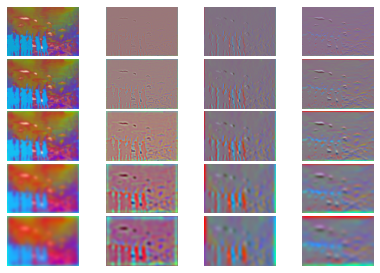

In [4]:
path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"
image = io.imread(path_img)
image = image.astype('float')/255

filter_responses = extract_filter_responses(image)
display_filter_responses(filter_responses)

### Q1.2 Creating Visual Words

You will now create a dictionary of visual words from the filter responses using `k-means`. After applying `k-means`, similar filter responses will be represented by the same visual word. You will use a dictionary with a fixed number of visual words. Instead of using all of the filter responses at each of the pixels from the given image **that can exceed the memory capacity of your computer**), you will use responses at $\alpha$ interest points from each image, chosen using the Harris Corner Detector. If there are $T$ training images, then you should collect a matrix ``filter_responses`` over all the images that is $\alpha * T \times 3F$, where $F$ is the filter bank size (20 in our case).

Then, to generate a visual words dictionary with $K$ words, you will cluster the responses with k-means using the function ``sklearn.cluster.KMeans`` as follows:
```
                kmeans = sklearn.cluster.KMeans(n_clusters=K).fit(filter_responses)
                dictionary = kmeans.cluster_centers_ }
```
You can alternatively pass the `n_jobs` argument into the ``KMeans()`` object to utilize parallel computation.

#### Q1.2.1 (10 Points -> 5 Autograder + 5 WriteUp)

As covered in class, the Harris Corner Detector is an effective way of selecting points of interest from images. This algorithm finds corners by building a covariance matrix of edge gradients within a region around a point in the image. The eigenvectors of this matrix point in the two directions of greatest change. If they are both large, then this indicates a corner. See class slides for more details.

In this question, you will implement:
```
    get_harris_points(image, alpha, k)}:
        return points_of_interest
```

This function takes the input image, $\alpha$ as number of points we want to choose, and k the sensitivity factor. The input image may either be a color or grayscale image, but the following operations should be done on the grayscale representation of the image (feel free to use functions from ``cv2``, ``skimage``, etc. for the conversion). For each pixel, you need to compute the covariance matrix:
$$ 
H=\left[\begin{array}{ll}
\sum_{p \in P} I_{x x} & \sum_{p \in P} I_{x y} \\
\sum_{p \in P} I_{y x} & \sum_{p \in P} I_{y y}
\end{array}\right]
$$
where $I_{a b}=\frac{\partial I}{\partial a} \frac{\partial I}{\partial b}$, and p is the current window.. You can use a $3 \times 3$ or $5 \times 5$ window. To compute image’s X and Y gradients, you can use the sobel filter (\eg ``cv2.Sobel(...)``). For the sum, also think about how you could do it using a convolution filter.

You then want to detect corners by finding pixels who’s covariance matrix eigenvalues are large. Since its expensive to compute the eigenvalues explicitly, you should instead compute the response function with:

$$R=\lambda_{1} \lambda_{2}-k\left(\lambda_{1}+\lambda_{2}\right)^{2}=\operatorname{det}(H)-k \operatorname{tr}(H)^{2}$$

$det$ represents the determinant and $tr$ denotes the trace of the matrix. Recall that when detecting corners with the Harris corner detector, corners are points where both eigenvalues are large. This is in contrast to edges (one eigenvalue is larger, while the other is small), and flat regions (both eigenvalues are small). In the response function, the first term becomes very small if one of the eigenvalues are small, thus making $R < 0$. Larger values of $R$ indicates similarly large eigenvalues.

Instead of thresholding the response function, simply take the top $\alpha$ response as the corners, and return their coordinates. A good value for the k parameter is 0.04 - 0.06. <font color="blue">**In your writeup: Show the results of your corner detector on 3 random images from the provided dataset.**</font>

**Note: You will be applying this function to a lot of images, try to implement this without loops using vectorization (you should have implemented something similar in HW1). However, there is no penalty if your implementation is slow.**

**Another Note: For the next part, you can also try selecting points of interest at random from the images and use it as a baseline method. Compare the two methods (Harris vs Random) and think about why the performance are different or similar. Make sure that your submitted version is using the Harris corner detector though, since we want to make sure that your implementation is sound.**

In [3]:
# Window size to compute the gradients with (actually WINDOWxWINDOW)
WINDOW = 5


def get_harris_points(image, alpha, k = 0.05):
    '''
    Compute points of interest using the Harris corner detector

    [input]
    * image: numpy.ndarray of shape (H, W) or (H, W, 3)
    * alpha: number of points of interest desired
    * k: senstivity factor 

    [output]
    * points_of_interest: numpy.ndarray of shape (2, alpha) that contains interest points
    '''
    
    '''
    HINTS:
    (1) Visualize and Compare results with cv2.cornerHarris() for debug (DO NOT SUBMIT cv2's implementation)
    '''
    
    ######### Actual Harris #########
    from skimage.color import rgb2gray
    from scipy import ndimage


    bw_img = rgb2gray(image)

    '''
    HINTS:
    1.> For derivative images we can use cv2.Sobel filter of 3x3 kernel size
    2.> For double derivate (e.g. dxx) think of re-using the previous output (e.g. dx)
    '''
    # YOUR CODE HERE
    # Not sure if BORDER_CONSTANT is important but it's what we've done before
    x_grad = cv2.Sobel(bw_img, ddepth=-1, dx=1, dy=0, ksize=3, borderType=cv2.BORDER_CONSTANT)
    y_grad = cv2.Sobel(bw_img, ddepth=-1, dx=0, dy=1, ksize=3, borderType=cv2.BORDER_CONSTANT)

    # According to L5 slide 40, Ixx is not a double derivative, it is Ix*Ix
    # Likewise Ixy is Ix * Iy
    Ixx = x_grad * x_grad
    Ixy = x_grad * y_grad
    Iyy = y_grad * y_grad

    '''
    HINTS:
    1.> Think of R = det - trace * k
    2.> We can use ndimage.convolve
    3.> sort (argsort) the values and pick the alpha larges ones
    3.> points_of_interest should have this structure [[x1,x2,x3...],[y1,y2,y3...]] (2,alpha)
        where x_i is across H and y_i is across W
    '''
    # To take the sum over an area, convolve with weights 1 everywhere
    size = (WINDOW, WINDOW)
    sum_Ixx = scipy.ndimage.convolve(Ixx, weights=np.ones(size), mode="constant")
    sum_Ixy = scipy.ndimage.convolve(Ixy, weights=np.ones(size), mode="constant")
    sum_Iyy = scipy.ndimage.convolve(Iyy, weights=np.ones(size), mode="constant")

    # Stack the arrays into the desired 2x2 shape, everywhere at once.
    # Combined will be of shape (N, M, 2, 2)
    row0 = np.dstack((sum_Ixx, sum_Ixy))
    row1 = np.dstack((sum_Ixy, sum_Iyy))
    combined = np.stack((row0, row1), axis=3)
    full_det = np.linalg.det(combined)
    full_trace = np.trace(combined, axis1=2, axis2=3)
    response = full_det - k * full_trace**2

    # This approach (sorting flat and then re-striding) doesn't feel like
    # cleanest way to do it, but I couldn't come up with a better one
    sorted_flat = np.argsort(response, axis=None)[-alpha:]
    # Because X is right (established by the filter choice, not explicitly
    # stated) then it will be axis 1
    stride = image.shape[1]
    x_pix = sorted_flat % stride
    # Likewise Y is down (established by the filter choice), so it will be
    # be the re-established axis 0
    y_pix = sorted_flat // stride

    ######### Actual Harris #########
    return np.array([y_pix, x_pix])


# image = np.zeros((7, 11, 3), dtype=np.float32)  # float32 needed by cv2.cornerHarris
# image[1, :10, :] = 1.0
# image[1:, 9, :] = 1.0
# from matplotlib import pyplot
# cv2version = cv2.cornerHarris(src=image[:, :, 0],
#                               blockSize=WINDOW,
#                               ksize=3,
#                               k=0.05)
# pyplot.imshow(image)
# pyplot.show()
# pyplot.imshow(cv2version)
# pyplot.show()
# print(get_harris_points(image, alpha=1, k = 0.05))

# # path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"
# path_img = "./data/waterfall/sun_bwzkjyclonamrgog.jpg"
# # path_img = "./data/windmill/sun_bnsthmtlderxjywh.jpg"
# # path_img = "./data/kitchen/sun_aaslbwtcdcwjukuo.jpg"
# image = io.imread(path_img).astype('float') / 255
# harris_points = get_harris_points(image, alpha=100)
# plot_harris_points(image, harris_points)

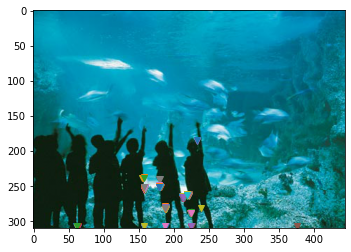

In [4]:
path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"
image = io.imread(path_img)
image = image.astype('float')/255

alpha = 100

harris_points = get_harris_points(image,alpha)
plot_harris_points(image, harris_points)

<font color="blue">**Show the results of your corner detector on 5 random images from the provided dataset.**</font>

#### Q1.2.2 (10 Points Autograder)

Now that we have a way to pick interest points from our images, we will build a dictionary using features from these points of interest. You should write the functions:
```
    def compute_dictionary_one_image(args):
  
    def compute_dictionary():
        
```
to generate a dictionary given a list of images. The overall goal of ``compute_dictionary()`` is to load the training data, iterate through the paths to the image files to read the images, and extract $\alpha T$ filter responses over the training files, and call k-means.

This can be slow to run; however, the images can be processed independently and in parallel.
Inside ``compute_dictionary_one_image()``, you should read an image, extract the responses, and save to a temporary file. Here, ``args`` is a collection of arguments passed into the function.

Inside ``compute_dictionary()``, you should load all the training data and create subprocesses to call `` compute_dictionary_one_image()``.

After all the subprocesses are finished, load the temporary files back, collect the filter responses, and run k-means.
A sensible initial value to try for $K$ is between $100$ and $300$, and for $\alpha$ is between $50$ and $500$, but they depend on your system configuration and you might want to play with these values.

Finally, execute ``compute_dictionary()`` and go get a coffee.
If all goes well, you will have a file named ``dictionary.npy`` that contains the dictionary of visual words. 
If the clustering takes too long, reduce the number of clusters and samples. If you have debugging issues, try passing in a small number of training files manually.

In [5]:
def compute_dictionary_one_image(args):
    '''
    Extracts samples of the dictionary entries from an image. Use the the 
    harris corner detector implmented from previous question to extract 
    the point of interests. This should be a function run by a subprocess.

    [input]
    * i: index of training image
    * alpha: number of samples
    * image_path: path of image file

    [saved]
    * sampled_response: numpy.ndarray of shape (alpha, 3F)
    '''
    i, alpha, image_path = args
    image = io.imread(image_path).astype('float') / 255
    
    if not os.path.isdir('tmp'):
        os.mkdir('tmp')

    filename = 'tmp/%05d.npy' % i
    # Short-circuit if the file already exists
    if os.path.isfile(filename):
        return
    
    # ----- TODO -----
    '''
    HINTS:
    1.> Create a tmp dir to store intermediate results.
    2.> Read the image from image_path using skimage
    3.> extract filter responses and points of interest
    4.> store the response of filters at points of interest 
    '''
    filter_responses = extract_filter_responses(image)
    points_of_interest = get_harris_points(image, alpha)
    # Save the data to file
    np.save(
        file=filename,
        arr=filter_responses[points_of_interest[0], points_of_interest[1]],
    )
    print("Saved {}, {}, {} to {}".format(i, alpha, image_path, filename))


# ARGS = [
#     (0, 4, "./data/windmill/sun_agudhwulyxcizdjv.jpg"),
#     (125, 4, "./data/highway/sun_bvoqrgcplsuyobvx.jpg"),
#     (1, 4, "./data/laundromat/sun_aodzngrfoqxcuxiq.jpg"),
#     (401, 4, "./data/kitchen/sun_anbnpmhqqitjribf.jpg"),   
# ]
# Useless unless you use ipdb to inspect things, because of the file saving
# for args in ARGS:
#     compute_dictionary_one_image(args)

In [8]:
def compute_dictionary(num_workers=2):
    '''
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * num_workers: number of workers to process in parallel

    [saved]
    * dictionary: numpy.ndarray of shape (K,3F)
    '''

    train_data = np.load("./data/train_data.npz")
    # ----- TODO -----
    list_of_args = []
    
    '''
    Can change these values for experiments, however please submit the dictionary.npy with these values
    alpha=150 and n_clusters = 200
    '''
    alpha = 150
    n_clusters = 200

    image_names = train_data['files']
    num_images = image_names.shape[0]
    print("Processing {} images total".format(num_images))
    print("=" * 80)

    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        list_of_args.append([i, alpha, full_image_name])

    with multiprocessing.Pool(num_workers) as p:
        p.map(compute_dictionary_one_image, list_of_args)
    
    '''
    HINTS:
    
    1.> Use multiprocessing for parallel processing of elements
    2.> Next, load the tmp files and stack the responses stored as npy
    '''
    filter_responses = np.concatenate(
        [np.load('tmp/%05d.npy' % i) for i in range(num_images)], 
        axis=0,
    )
    
    '''
    HINTS:
    1.> use sklearn.cluster.KMeans for clustersing
    2.> dictionary will be the cluster_centers_
    '''
    print("Starting the cluster operation")
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(filter_responses)
    np.save('dictionary.npy', kmeans.cluster_centers_)


compute_dictionary(num_workers=2)

**For this assignment, upload a `dictionary.npy` file along with ``alpha = 150`` and ``n_clusters = 200`` for autograding.**

#### Q1.3.1 (10 Points -> 5 Autograder + 5 WriteUp)
<img align="center" src="./figures/textons.jpg" width="800">
<figcaption align = "center"><b>Figure 6. Visual words over images. You will use the spatially un-ordered distribution of visual words in a region (a bag of visual words) as a feature for scene classification, with some coarse information provided by spatial pyramid matching [2]</b></figcaption>

We want to map each pixel in the image to its closest word in the dictionary.

Complete the following function to do this:
```
                def get_visual_words(image,dictionary):
                    return wordmap
```
and return $wordmap$, a matrix with the same width and height as $image$, where each pixel in $wordmap$ is matched to the closest visual word based on the filter response at the respective pixel in $image$. We will use the standard Euclidean distance to match the filter response and our visual words; to do this efficiently, use the function `` scipy.spatial.distance.cdist()``. Some sample results are shown in Fig. 6.

In [13]:
def get_visual_words(image, dictionary):
    '''
    Compute visual words mapping for the given image using the dictionary of visual words.

    [input]
    * image: numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    '''
    '''
    HINTS:
    (1) Use scipy.spatial.distance.cdist to find closest match from dictionary
    (2) Wordmap represents the indices of the closest element (np.argmin) in the dictionary
    '''
    filter_responses = extract_filter_responses(image)
    
    h, w, _ = filter_responses.shape
    filter_responses = np.reshape(filter_responses, [-1, filter_responses.shape[-1]])
    # ----- TODO -----

    # Makes a matrix of (num pixels, num words), e.g. (167000, 200), where it gives
    # the distance of each pixel response to each word
    dist_matrix = scipy.spatial.distance.cdist(XA=filter_responses, XB=dictionary)
    # Per-pixel, gets the word index with the lowest distance
    closest = np.argmin(dist_matrix, axis=1)
    wordmap = closest.reshape((h, w))
    
    return wordmap

# # Just a little test of argmin
# a = np.array([
#     [0.1, 1, 0, 0.2],
#     [0.1, 1, 0.5, 10],
#     [10, 1, 100, 1000],
# ])
# print("a\n", a)
# print("np.argmin(a)\n", np.argmin(a, axis=1))

# from matplotlib import pyplot
# from util import save_wordmap
# dictionary = np.load('dictionary.npy')

# # path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"
# # path_img = "./data/waterfall/sun_bwzkjyclonamrgog.jpg"
# # path_img = "./data/windmill/sun_bnsthmtlderxjywh.jpg"
# path_img = "./data/kitchen/sun_aaslbwtcdcwjukuo.jpg"

# image = io.imread(path_img).astype('float') / 255
# pyplot.imshow(image)
# pyplot.show()

# wordmap = get_visual_words(image, dictionary)
# print("Wordmap generated, saving")
# save_wordmap(wordmap, "viz_wordmap.png")

<font color="blue">Visualize three wordmaps of images from any one of the category. **Include these in your write-up, along with the original RGB images. Include some comments on these visualizations: do the “word” boundaries make sense to you?**. We have provided helper function to save and visualize the resulting wordmap in the util.py file. </font> They should look similar to the ones in Figure 6.

### References

[1]  James Hays and Alexei A Efros. Scene completion using millions of photographs.ACM Transactions onGraphics (SIGGRAPH 2007), 26(3), 2007.

[2]  S. Lazebnik, C. Schmid, and J. Ponce. Beyond bags of features: Spatial pyramid matching for recogniz-ing natural scene categories.  InComputer Vision and Pattern Recognition (CVPR), 2006 IEEE Conferenceon, volume 2, pages 2169–2178, 2006.

[3]  Jian xiong Xiao, J. Hays, K. Ehinger, A. Oliva, and A. Torralba. Sun database: Large-scale scene recogni-tion from abbey to zoo.2010 IEEE Computer Society Conference on Computer Vision and Pattern Recognition,pages 3485–3492, 2010.14

### Q1.1.2 Manually grade the image

Can use `sun_aztvjgubyrgvirup.jpg` for visualizing the 20 image collage

YOUR ANSWER HERE

### Q1.2.1 Manually grade 5 images for Harris Corner

YOUR ANSWER HERE